### Data

In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from tensorflow import keras
from keras import layers
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from sklearn.preprocessing import LabelEncoder


# import the data from all sheets of the Excel file

df0 = pd.read_excel('Datos1_InteraccionesNIR.xlsx', sheet_name=0)
df1 = pd.read_excel('Datos1_InteraccionesNIR.xlsx', sheet_name=1)
df2 = pd.read_excel('Datos1_InteraccionesNIR.xlsx', sheet_name=2)
df3 = pd.read_excel('Datos1_InteraccionesNIR.xlsx', sheet_name=3)

# Concatenate all sheets into a single DataFrame
df = pd.concat([df0, df1, df2, df3], ignore_index=True)

### Data preparation for production of models

In [2]:
# Data preparation for model production
X = df.iloc[:, 3:].values  
y = df['Tratamiento'].values  

#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Model 
for the model we still need a clasification algorithm, that classify the data into the treatments based on the PCA components. 
Let's use KNN, SVM and encoders to see which one works better. 

#### KNN

In [3]:
# Define the parameter grid
param_grid = {
    'pca__n_components': [10, 20, 30],            
    'knn__n_neighbors': list(range(1, 10)),          
    'knn__weights': ['uniform', 'distance'],          
    'knn__metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev'],
    'knn__algorithm': ['auto','ball_tree', 'kd_tree', 'brute'], 
    'knn__leaf_size': [10, 30, 50]
}

pipeline = Pipeline([    
    ('pca', PCA()),                   
    ('knn', KNeighborsClassifier())  
])

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='balanced_accuracy')

grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 2592 candidates, totalling 12960 fits


c:\Users\ricar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.37348485 0.37575758 0.37922078 ... 0.36255411 0.36255411 0.36255411]
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__algorithm': ['auto', 'ball_tree', 'kd_tree',
                                            'brute'],
                         'knn__leaf_size': [10, 30, 50],
                         'knn__metric': ['euclidean', 'manhattan', 'minkowski',
                                         'chebyshev'],
                         'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'knn__weights': ['uniform', 'distance'],
                         'pca__n_components': [10, 20, 30]},
             scoring='balanced_accuracy', verbose=1)

In [4]:
print(f"Best cross-validation score (Accuracy): {grid_search.best_score_:.4f}")
print("Best parameters found:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
accuracy = best_model.score(X_test, y_test)
print(f"\nAccuracy on the test set: {accuracy:.4f}")

y_pred = best_model.predict(X_test)

Best cross-validation score (Accuracy): 0.4378
Best parameters found:
{'knn__algorithm': 'auto', 'knn__leaf_size': 10, 'knn__metric': 'manhattan', 'knn__n_neighbors': 6, 'knn__weights': 'distance', 'pca__n_components': 30}

Accuracy on the test set: 0.4167


<Figure size 1600x1200 with 0 Axes>

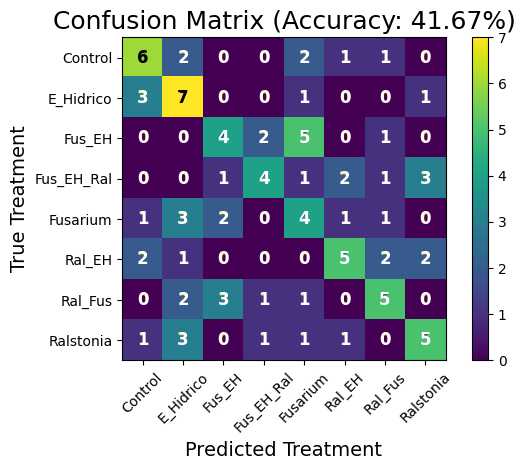

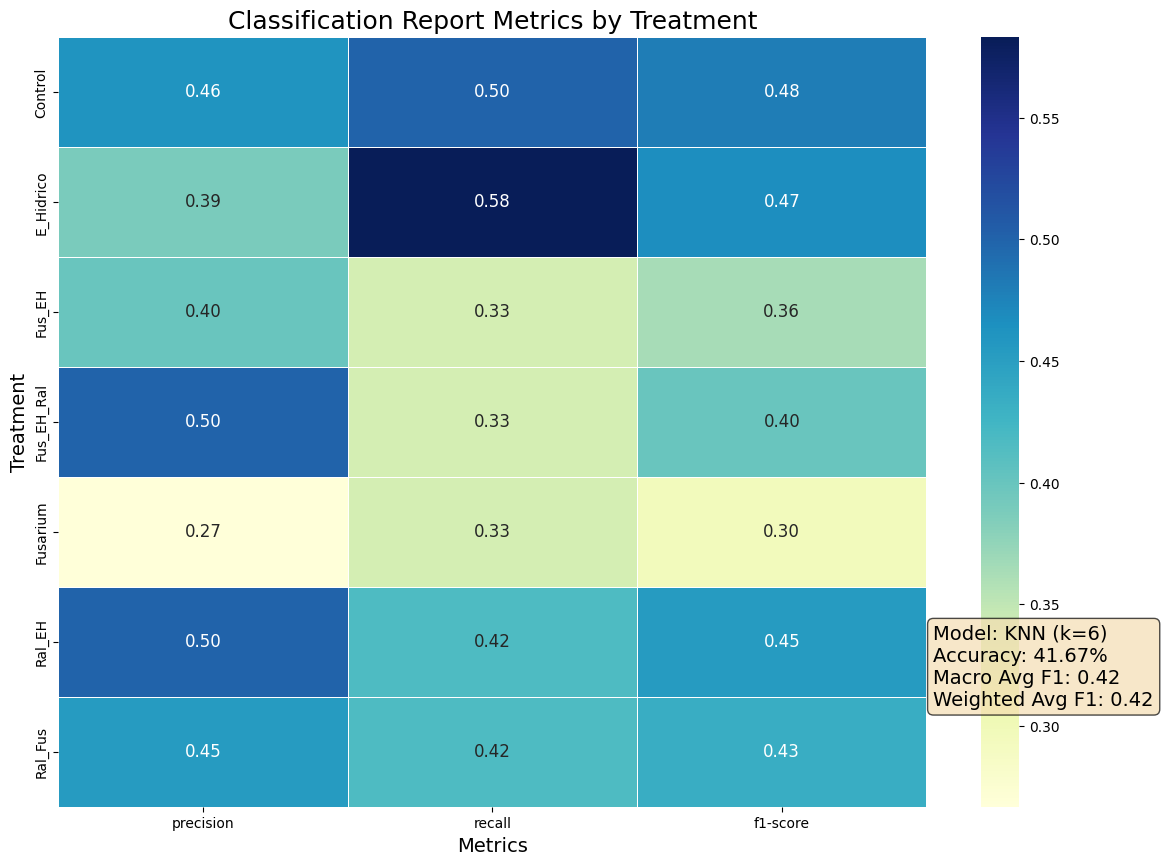

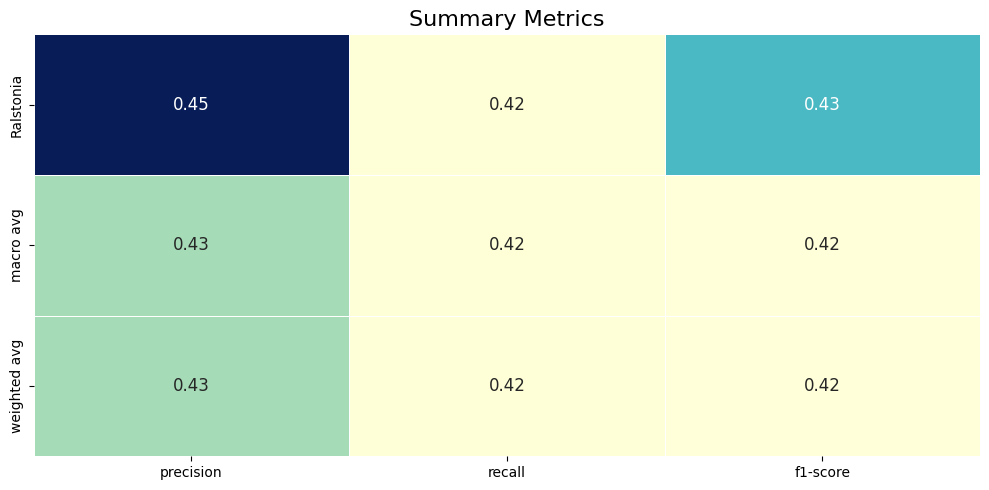

Overall model accuracy: 41.67%

Classification Report:
              precision    recall  f1-score   support

     Control       0.46      0.50      0.48        12
   E_Hidrico       0.39      0.58      0.47        12
      Fus_EH       0.40      0.33      0.36        12
  Fus_EH_Ral       0.50      0.33      0.40        12
    Fusarium       0.27      0.33      0.30        12
      Ral_EH       0.50      0.42      0.45        12
     Ral_Fus       0.45      0.42      0.43        12
   Ralstonia       0.45      0.42      0.43        12

    accuracy                           0.42        96
   macro avg       0.43      0.42      0.42        96
weighted avg       0.43      0.42      0.42        96



In [5]:
# ---------- PLOT 1: CONFUSION MATRIX ----------
plt.figure(figsize=(16, 12))

# Enhanced confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
labels = sorted(df['Tratamiento'].unique())

# Create confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='viridis', colorbar=True, xticks_rotation=45)
plt.title(f'Confusion Matrix (Accuracy: {accuracy:.2%})', fontsize=18)
plt.xlabel('Predicted Treatment', fontsize=14)
plt.ylabel('True Treatment', fontsize=14)

# Add value annotations to confusion matrix
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text_color = 'white' if plt.cm.viridis(cm[i, j]/cm.max())[0] < 0.5 else 'black'
        plt.text(j, i, cm[i, j], ha='center', va='center', color=text_color, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# ---------- PLOT 2: CLASSIFICATION REPORT ----------
plt.figure(figsize=(14, 10))

# Enhanced classification report visualization
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).T
report_df = report_df.drop('accuracy', errors='ignore')  # Remove the accuracy row

# Create heatmap for classification metrics
ax = sns.heatmap(report_df.iloc[:-3, :3], annot=True, cmap='YlGnBu', fmt='.2f', 
        linewidths=0.5, cbar=True, annot_kws={"size": 12})
plt.title('Classification Report Metrics by Treatment', fontsize=18)
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Treatment', fontsize=14)

# Add a text box with overall model performance
props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
textstr = (f'Model: KNN (k={grid_search.best_params_["knn__n_neighbors"]})\n'
           f'Accuracy: {accuracy:.2%}\n'
           f'Macro Avg F1: {report["macro avg"]["f1-score"]:.2f}\n'
           f'Weighted Avg F1: {report["weighted avg"]["f1-score"]:.2f}')
plt.gcf().text(0.75, 0.25, textstr, fontsize=14,
        verticalalignment='center', bbox=props)

# Add the summary metrics at the bottom
summary_df = report_df.iloc[-3:, :3]
plt.figure(figsize=(10, 5))
sns.heatmap(summary_df, annot=True, cmap='YlGnBu', fmt='.2f',
           linewidths=0.5, cbar=False, annot_kws={"size": 12})
plt.title('Summary Metrics', fontsize=16)

plt.tight_layout()
plt.show()

# Print additional performance details
print(f"Overall model accuracy: {accuracy:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

### SVM

In [6]:
param_grid = {
    'pca__n_components': [5, 10, 15, 20, 30, 40],
    'svm__C': [0.01, 0.1, 1, 10, 100],
    'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'svm__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'svm__degree': [2, 3, 4],
    'svm__class_weight': ['balanced', None]
}

pipeline = Pipeline([    
    ('pca', PCA()),                   
    ('svm', SVC())  
])

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='balanced_accuracy')

grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 4320 candidates, totalling 21600 fits


GridSearchCV(cv=5, estimator=Pipeline(steps=[('pca', PCA()), ('svm', SVC())]),
             n_jobs=-1,
             param_grid={'pca__n_components': [5, 10, 15, 20, 30, 40],
                         'svm__C': [0.01, 0.1, 1, 10, 100],
                         'svm__class_weight': ['balanced', None],
                         'svm__degree': [2, 3, 4],
                         'svm__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
                         'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             scoring='balanced_accuracy', verbose=1)

In [7]:
print(f"Best cross-validation score (Accuracy): {grid_search.best_score_:.4f}")
print("Best parameters found:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
accuracy = best_model.score(X_test, y_test)
print(f"\nAccuracy on the test set: {accuracy:.4f}")

y_pred = best_model.predict(X_test)

Best cross-validation score (Accuracy): 0.5637
Best parameters found:
{'pca__n_components': 40, 'svm__C': 100, 'svm__class_weight': 'balanced', 'svm__degree': 2, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}

Accuracy on the test set: 0.5729


<Figure size 1600x1200 with 0 Axes>

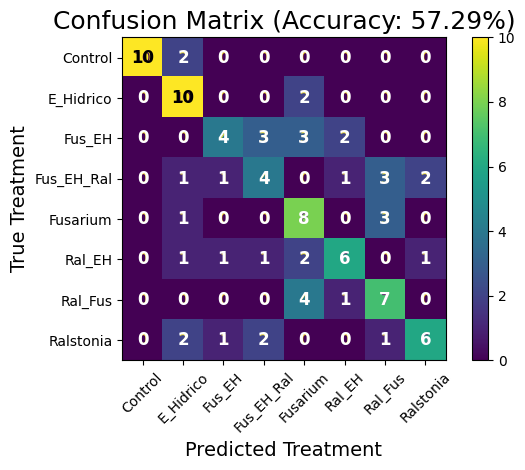

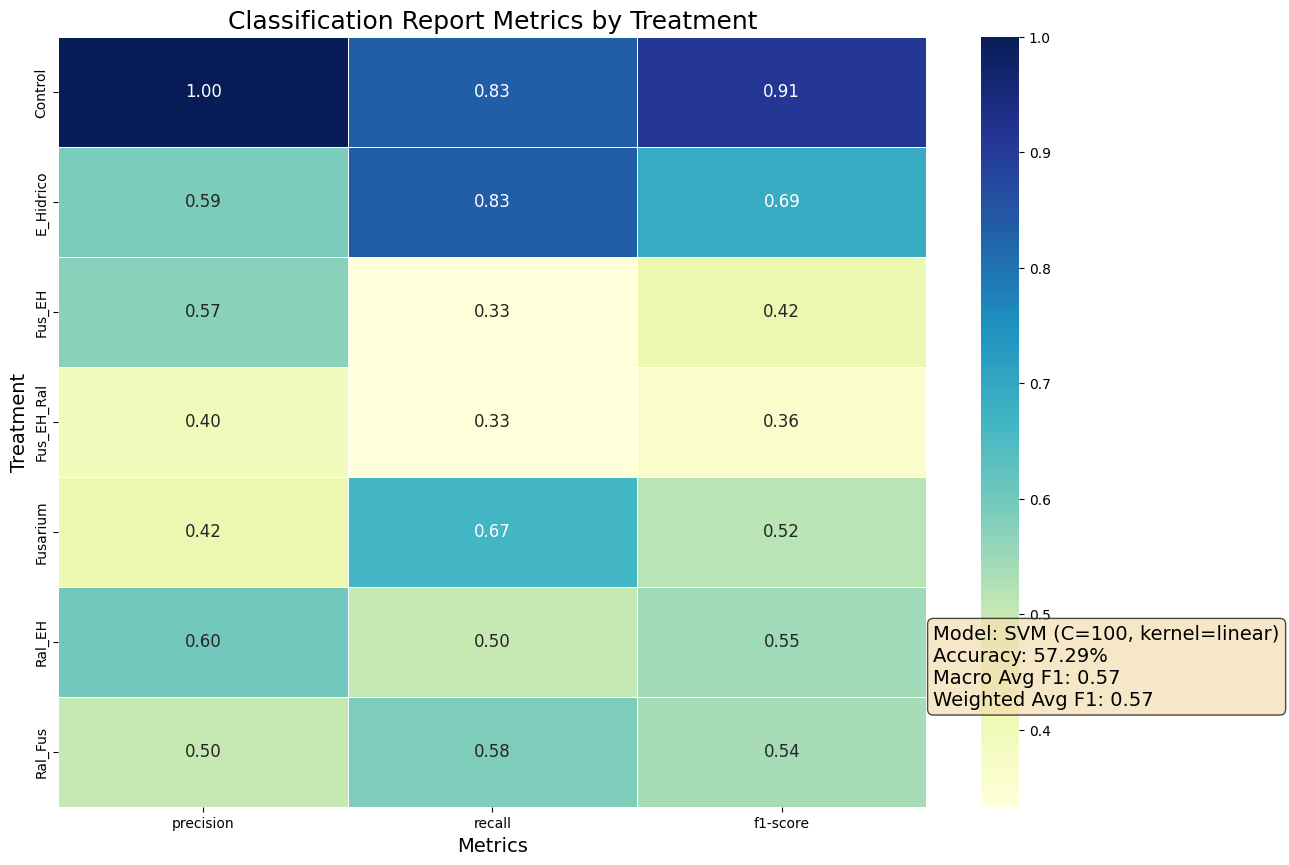

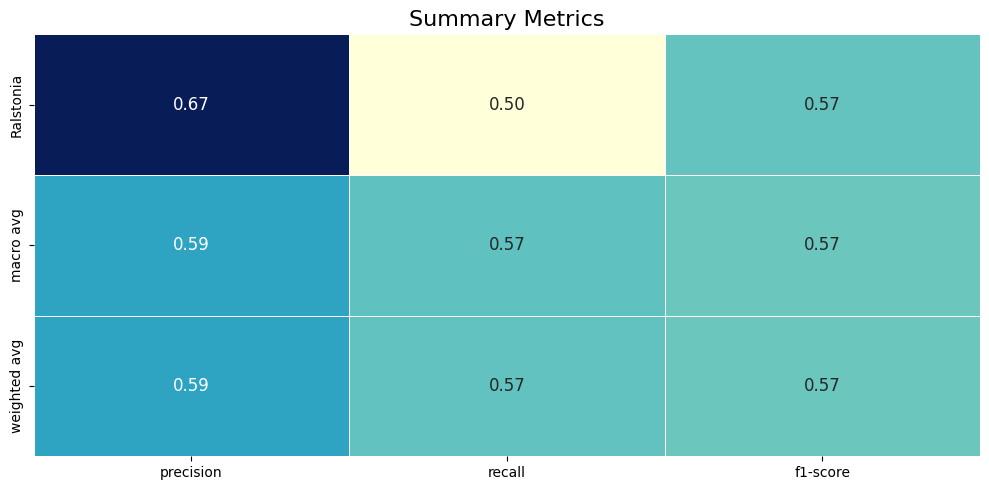

Overall model accuracy: 57.29%

Classification Report:
              precision    recall  f1-score   support

     Control       1.00      0.83      0.91        12
   E_Hidrico       0.59      0.83      0.69        12
      Fus_EH       0.57      0.33      0.42        12
  Fus_EH_Ral       0.40      0.33      0.36        12
    Fusarium       0.42      0.67      0.52        12
      Ral_EH       0.60      0.50      0.55        12
     Ral_Fus       0.50      0.58      0.54        12
   Ralstonia       0.67      0.50      0.57        12

    accuracy                           0.57        96
   macro avg       0.59      0.57      0.57        96
weighted avg       0.59      0.57      0.57        96



In [8]:
# ---------- PLOT 1: CONFUSION MATRIX ----------
plt.figure(figsize=(16, 12))

# Enhanced confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
labels = sorted(df['Tratamiento'].unique())

# Create confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='viridis', colorbar=True, xticks_rotation=45)
plt.title(f'Confusion Matrix (Accuracy: {accuracy:.2%})', fontsize=18)
plt.xlabel('Predicted Treatment', fontsize=14)
plt.ylabel('True Treatment', fontsize=14)

# Add value annotations to confusion matrix
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text_color = 'white' if plt.cm.viridis(cm[i, j]/cm.max())[0] < 0.5 else 'black'
        plt.text(j, i, cm[i, j], ha='center', va='center', color=text_color, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# ---------- PLOT 2: CLASSIFICATION REPORT ----------
plt.figure(figsize=(14, 10))

# Enhanced classification report visualization
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).T
report_df = report_df.drop('accuracy', errors='ignore')  # Remove the accuracy row

# Create heatmap for classification metrics
ax = sns.heatmap(report_df.iloc[:-3, :3], annot=True, cmap='YlGnBu', fmt='.2f', 
        linewidths=0.5, cbar=True, annot_kws={"size": 12})
plt.title('Classification Report Metrics by Treatment', fontsize=18)
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Treatment', fontsize=14)

# Add a text box with overall model performance
props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
textstr = (f'Model: SVM (C={grid_search.best_params_["svm__C"]}, kernel={grid_search.best_params_["svm__kernel"]})\n'
           f'Accuracy: {accuracy:.2%}\n'
           f'Macro Avg F1: {report["macro avg"]["f1-score"]:.2f}\n'
           f'Weighted Avg F1: {report["weighted avg"]["f1-score"]:.2f}')
plt.gcf().text(0.75, 0.25, textstr, fontsize=14,
        verticalalignment='center', bbox=props)

# Add the summary metrics at the bottom
summary_df = report_df.iloc[-3:, :3]
plt.figure(figsize=(10, 5))
sns.heatmap(summary_df, annot=True, cmap='YlGnBu', fmt='.2f',
           linewidths=0.5, cbar=False, annot_kws={"size": 12})
plt.title('Summary Metrics', fontsize=16)

plt.tight_layout()
plt.show()

# Print additional performance details
print(f"Overall model accuracy: {accuracy:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

### MLP (Multi Layer Perceptron)

In [9]:
pca = PCA(n_components=40)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# Encode categorical labels to integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
num_classes = len(label_encoder.classes_)

# Define the model-building function
def build_model(hp):
    model = keras.Sequential()
    
    # Input layer
    model.add(layers.Input(shape=(40,)))  # 40 PCA components
    
    # Add between 1-3 hidden layers
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(
            layers.Dense(
                units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32),
                activation=hp.Choice(f'activation_{i}', ['relu', 'tanh', 'elu'])
            )
        )
        
        # Optional BatchNormalization
        if hp.Boolean(f'batch_norm_{i}'):
            model.add(layers.BatchNormalization())
            
        # Dropout rate
        model.add(layers.Dropout(hp.Float(f'dropout_{i}', 0, 0.5, step=0.1)))
    
    # Output layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Set up the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    # Try 50 different configurations  
    max_trials=50,  
    # Run each trial twice to reduce variance
    executions_per_trial=2,  
    directory='mlp_tuning',
    project_name='pca_mlp'
)

# Early stopping
stop_early = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Start the search
tuner.search(
    X_train, y_train_encoded,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[stop_early]
)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Train the best model with full dataset
history = best_model.fit(
    X_train, y_train_encoded,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[stop_early]
)

#Evaluate the best model
y_pred_prob = best_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_pred_labels = label_encoder.inverse_transform(y_pred)



Reloading Tuner from mlp_tuning\pca_mlp\tuner0.json
Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2314 - loss: 1.9514 - val_accuracy: 0.2209 - val_loss: 1.8781
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3319 - loss: 1.7640 - val_accuracy: 0.3953 - val_loss: 1.7093
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4017 - loss: 1.6220 - val_accuracy: 0.3547 - val_loss: 1.6199
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3872 - loss: 1.5313 - val_accuracy: 0.4128 - val_loss: 1.5455
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4469 - loss: 1.4391 - val_accuracy: 0.4302 - val_loss: 1.4694
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4672 - loss: 1.3504 - val_accuracy: 0.4884 - val_loss: 1.4231
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4891 - loss: 1.3142 - val_accuracy: 0.4942 - val_loss: 1.3539
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accura

Best MLP Accuracy: 0.6875

Classification Report:
              precision    recall  f1-score   support

     Control       0.92      0.92      0.92        12
   E_Hidrico       0.92      0.92      0.92        12
      Fus_EH       0.70      0.58      0.64        12
  Fus_EH_Ral       0.38      0.42      0.40        12
    Fusarium       0.82      0.75      0.78        12
      Ral_EH       0.67      0.33      0.44        12
     Ral_Fus       0.57      0.67      0.62        12
   Ralstonia       0.61      0.92      0.73        12

    accuracy                           0.69        96
   macro avg       0.70      0.69      0.68        96
weighted avg       0.70      0.69      0.68        96


Best Hyperparameters:
num_layers: 1
units_0: 480
activation_0: relu
batch_norm_0: False
dropout_0: 0.4
learning_rate: 0.004798846470079632
units_1: 224
activation_1: tanh
batch_norm_1: False
dropout_1: 0.2
units_2: 416
activation_2: tanh
batch_norm_2: False
dropout_2: 0.2


<Figure size 1600x1200 with 0 Axes>

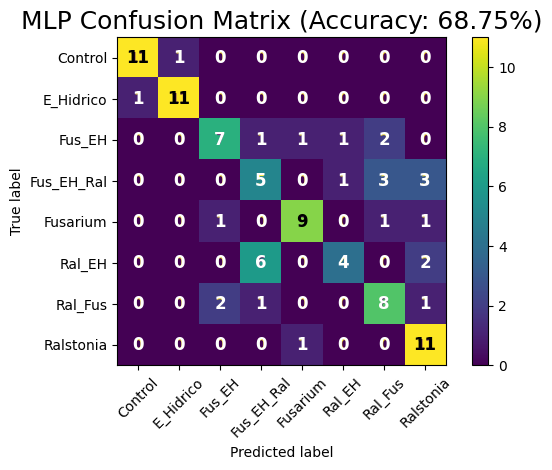

In [10]:
# Print results
print(f"Best MLP Accuracy: {accuracy_score(y_test, y_pred_labels):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_labels))

# Print the best hyperparameters
print("\nBest Hyperparameters:")
for param, value in best_hps.values.items():
    print(f"{param}: {value}")

# Plot confusion matrix
plt.figure(figsize=(16, 12))
cm = confusion_matrix(y_test, y_pred_labels)
labels = sorted(df['Tratamiento'].unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='viridis', colorbar=True, xticks_rotation=45)

# Add value annotations to confusion matrix
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text_color = 'white' if plt.cm.viridis(cm[i, j]/cm.max())[0] < 0.5 else 'black'
        plt.text(j, i, cm[i, j], ha='center', va='center', color=text_color, fontsize=12, fontweight='bold')


plt.title(f'MLP Confusion Matrix (Accuracy: {accuracy_score(y_test, y_pred_labels):.2%})', fontsize=18)
plt.tight_layout()
plt.show()